In [ ]:
!pip install yfinance
import numpy as np
import yfinance as yf
from scipy.optimize import minimize  # Correct import statement
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
# Download historical data for a set of assets from the Indian stock market
tickers = ['TCS.NS', 'TATAMOTORS.NS', 'INFY.NS', 'BAJFINANCE.NS', 'ASHOKLEY.NS']
data = yf.download(tickers, start="2014-01-01", end="2024-01-01")['Adj Close']  #10year data
print(data.head(5))


[*********************100%***********************]  5 of 5 completed

Ticker                     ASHOKLEY.NS  BAJFINANCE.NS     INFY.NS  \
Date                                                                
2014-01-01 00:00:00+00:00    13.647117     151.244644  335.909393   
2014-01-02 00:00:00+00:00    14.083504     151.138687  337.125000   
2014-01-03 00:00:00+00:00    14.995957     149.819214  345.319305   
2014-01-06 00:00:00+00:00    14.837273     149.429092  340.742706   
2014-01-07 00:00:00+00:00    14.559568     149.679504  334.858429   

Ticker                     TATAMOTORS.NS      TCS.NS  
Date                                                  
2014-01-01 00:00:00+00:00     366.963165  864.619324  
2014-01-02 00:00:00+00:00     364.418549  870.120422  
2014-01-03 00:00:00+00:00     354.974091  892.285034  
2014-01-06 00:00:00+00:00     359.133545  899.271423  
2014-01-07 00:00:00+00:00     357.322968  885.840271  


In [ ]:
#Calculating daily returns
returns = data.pct_change().dropna()

In [ ]:
# Calculate the Sharpe ratio of each asset
mean_returns = returns.mean() * 252  # Annualized mean returns
cov_matrix = returns.cov() * 252      # Annualized covariance matrix
risk_free_rate = 0.06  # Assume a risk-free rate of 6%

sharpe_ratios = (mean_returns - risk_free_rate) / returns.std() * np.sqrt(252)
print("Sharpe Ratios of the assets:")
print(sharpe_ratios)

# Identify the stock with the highest Sharpe ratio
max_sharpe_stock = sharpe_ratios.idxmax()
max_sharpe_value = sharpe_ratios.max()

# Calculate risk and return for the stock with the highest Sharpe ratio
max_sharpe_stock_return = mean_returns[max_sharpe_stock]
max_sharpe_stock_risk = returns[max_sharpe_stock].std() * np.sqrt(252)

Sharpe Ratios of the assets:
Ticker
ASHOKLEY.NS      175.954197
BAJFINANCE.NS    276.668754
INFY.NS          123.769308
TATAMOTORS.NS     62.489626
TCS.NS           124.507607
dtype: float64


In [ ]:
# Construct a maximum Sharpe ratio portfolio
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    returns = np.sum(weights * mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (returns - risk_free_rate) / std
    return std, returns, sharpe

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

optimal_portfolio = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimal_portfolio['x']

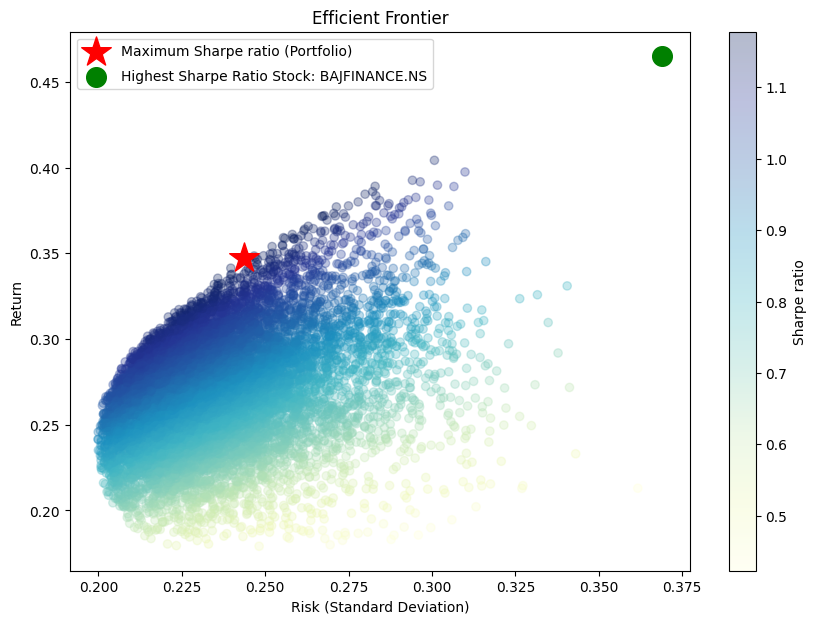

In [ ]:
#  Plot the efficient frontier and the maximum Sharpe ratio portfolio
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.sum(mean_returns * weights)

def efficient_frontier(mean_returns, cov_matrix, risk_free_rate, num_portfolios=10000):
    results = np.zeros((4, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return_, portfolio_sharpe = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return_
        results[2,i] = portfolio_sharpe
        results[3,i] = np.sum(weights * mean_returns)

    return results, weights_record

results, weights = efficient_frontier(mean_returns, cov_matrix, risk_free_rate)

max_sharpe_idx = np.argmax(results[2])
sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]

plt.figure(figsize=(10, 7))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o', alpha=0.3)
plt.colorbar(label='Sharpe ratio')
plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe ratio (Portfolio)')
plt.scatter(max_sharpe_stock_risk, max_sharpe_stock_return, marker='o', color='g', s=200, label=f'Highest Sharpe Ratio Stock: {max_sharpe_stock}')
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)

In [ ]:
# Table of Risk, Sharpe ratio, Returns, and Portfolio composition
risk_levels = [0.05, 0.1, 0.15, 0.2, 0.25]  # Example risk levels
table = []

# Ensure bounds is defined in the scope
bounds = tuple((0, 1) for asset in range(len(mean_returns)))

for risk in risk_levels:
    def portfolio_return_for_given_risk(weights):
        return abs(portfolio_variance(weights, cov_matrix) - risk**2)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_return_for_given_risk, len(mean_returns)*[1./len(mean_returns),],
                      method='SLSQP', bounds=bounds, constraints=constraints)
    ret = portfolio_return(result['x'], mean_returns)
    std = np.sqrt(portfolio_variance(result['x'], cov_matrix))
    sharpe = (ret - risk_free_rate) / std
    table.append([std, sharpe, ret, result['x']])

columns = ['Risk', 'Sharpe Ratio', 'Returns', 'Portfolio Composition (Weights)']
df = pd.DataFrame(table, columns=columns)

print(df)
plt.show()

       Risk  Sharpe Ratio   Returns  \
0  0.199419      0.902048  0.239885   
1  0.199419      0.902048  0.239885   
2  0.199419      0.902048  0.239885   
3  0.200000      0.904424  0.240885   
4  0.250000      0.879086  0.279771   

                     Portfolio Composition (Weights)  
0  [0.11826418884115719, 0.1358712480012168, 0.25...  
1  [0.11826418884115719, 0.1358712480012168, 0.25...  
2  [0.11826418884115719, 0.1358712480012168, 0.25...  
3  [0.10966645909961964, 0.1418606639486953, 0.31...  
4  [0.2482964496817946, 0.2162545166417614, 0.139...  
